## Librerías

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, HillClimbSearch, BicScore, MmhcEstimator, PC, BDeuScore

## Dataset

In [27]:
test_df = pd.read_csv('dataset/student_addiction_dataset_test.csv')
train_df = pd.read_csv('dataset/student_addiction_dataset_train.csv')

In [28]:
test_df.shape, train_df.shape

((12744, 11), (50342, 11))

## Transformar valores

In [29]:
test_df.head()

,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
0,Yes,Yes,Yes,No,Yes,No,No,No,Yes,No,No
1,No,No,Yes,No,No,Yes,No,Yes,No,No,No
2,No,No,No,Yes,No,Yes,No,No,Yes,No,No
3,Yes,No,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes
4,No,No,No,No,Yes,No,No,No,No,Yes,No


In [30]:
train_df.head()

,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
0,Yes,No,No,Yes,No,No,No,Yes,No,No,No
1,No,Yes,NaN,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes
2,No,No,No,No,No,Yes,Yes,Yes,No,No,No
3,Yes,No,Yes,Yes,No,Yes,No,No,No,Yes,Yes
4,Yes,Yes,No,NaN,No,Yes,Yes,Yes,No,No,Yes


In [31]:
pd.set_option('future.no_silent_downcasting', True)
train_df = train_df.replace({'Yes': 1, 'No': 0})
test_df = test_df.replace({'Yes': 1, 'No': 0})

In [32]:
train_df.head()

,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
0,1,0,0,1,0,0,0,1,0,0,0
1,0,1,NaN,1,1,1,1,1,1,0,1
2,0,0,0,0,0,1,1,1,0,0,0
3,1,0,1,1,0,1,0,0,0,1,1
4,1,1,0,NaN,0,1,1,1,0,0,1


In [33]:
test_df.head()

,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
0,1,1,1,0,1,0,0,0,1,0,0
1,0,0,1,0,0,1,0,1,0,0,0
2,0,0,0,1,0,1,0,0,1,0,0
3,1,0,1,0,1,1,0,1,0,1,1
4,0,0,0,0,1,0,0,0,0,1,0


## Eliminar y transformar nulos

In [34]:
tiene_nulls = test_df.isnull().sum()
tiene_nulls

Experimentation                       645
Academic_Performance_Decline          685
Social_Isolation                      677
Financial_Issues                      620
Physical_Mental_Health_Problems       665
Legal_Consequences                    686
Relationship_Strain                   632
Risk_Taking_Behavior                  613
Withdrawal_Symptoms                   653
Denial_and_Resistance_to_Treatment    654
Addiction_Class                         0
dtype: int64

In [35]:
tiene_nulls = test_df.isnull().sum(axis=1)
conteo_nulls = tiene_nulls.value_counts().sort_index()
conteo_nulls

0    7516
1    4096
2     983
3     130
4      17
5       2
Name: count, dtype: int64

In [36]:
test_df_filtrado = test_df.dropna(thresh=test_df.shape[1] - 2)

In [37]:
promedios = test_df_filtrado.mean()
for col in test_df_filtrado.columns:
    nuevo_valor = 1 if promedios[col] > 0.5 else 0
    test_df_filtrado.loc[:, col] = test_df_filtrado[col].fillna(nuevo_valor)

In [38]:
tiene_nulls = test_df_filtrado.isnull().sum()
tiene_nulls

Experimentation                       0
Academic_Performance_Decline          0
Social_Isolation                      0
Financial_Issues                      0
Physical_Mental_Health_Problems       0
Legal_Consequences                    0
Relationship_Strain                   0
Risk_Taking_Behavior                  0
Withdrawal_Symptoms                   0
Denial_and_Resistance_to_Treatment    0
Addiction_Class                       0
dtype: int64

In [39]:
test_df_filtrado.head()

,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
0,1,1,1,0,1,0,0,0,1,0,0
1,0,0,1,0,0,1,0,1,0,0,0
2,0,0,0,1,0,1,0,0,1,0,0
3,1,0,1,0,1,1,0,1,0,1,1
4,0,0,0,0,1,0,0,0,0,1,0


In [40]:
tiene_nulls = train_df.isnull().sum()
tiene_nulls

Experimentation                       2562
Academic_Performance_Decline          2498
Social_Isolation                      2550
Financial_Issues                      2537
Physical_Mental_Health_Problems       2454
Legal_Consequences                    2576
Relationship_Strain                   2543
Risk_Taking_Behavior                  2577
Withdrawal_Symptoms                   2612
Denial_and_Resistance_to_Treatment    2453
Addiction_Class                          0
dtype: int64

In [41]:
tiene_nulls = train_df.isnull().sum(axis=1)
conteo_nulls = tiene_nulls.value_counts().sort_index()
conteo_nulls

0    30072
1    15809
2     3870
3      553
4       36
5        2
Name: count, dtype: int64

In [42]:
train_df_filtrado = train_df.dropna(thresh=train_df.shape[1] - 2)

In [43]:
promedios = train_df_filtrado.mean()
for col in train_df_filtrado.columns:
    nuevo_valor = 1 if promedios[col] > 0.5 else 0
    train_df_filtrado.loc[:, col] = train_df_filtrado[col].fillna(nuevo_valor)

In [44]:
tiene_nulls = train_df_filtrado.isnull().sum()
tiene_nulls

Experimentation                       0
Academic_Performance_Decline          0
Social_Isolation                      0
Financial_Issues                      0
Physical_Mental_Health_Problems       0
Legal_Consequences                    0
Relationship_Strain                   0
Risk_Taking_Behavior                  0
Withdrawal_Symptoms                   0
Denial_and_Resistance_to_Treatment    0
Addiction_Class                       0
dtype: int64

# Balanceo de clases

In [45]:
test_df_filtrado['Addiction_Class'].value_counts()

Addiction_Class
0    9984
1    2611
Name: count, dtype: int64

In [46]:
train_df_filtrado['Addiction_Class'].value_counts()

Addiction_Class
0    34856
1    14895
Name: count, dtype: int64

# Analisis previo

In [47]:
train_df_filtrado.describe()

,Experimentation,Academic_Performance_Decline,Social_Isolation,Financial_Issues,Physical_Mental_Health_Problems,Legal_Consequences,Relationship_Strain,Risk_Taking_Behavior,Withdrawal_Symptoms,Denial_and_Resistance_to_Treatment,Addiction_Class
count,49751,49751,49751,49751,49751,49751,49751,49751,49751,49751,49751
unique,2,2,2,2,2,2,2,2,2,2,2
top,1,1,1,1,0,0,1,0,1,1,0
freq,26179,26085,26068,26167,26063,26098,26171,26142,26283,26127,34856


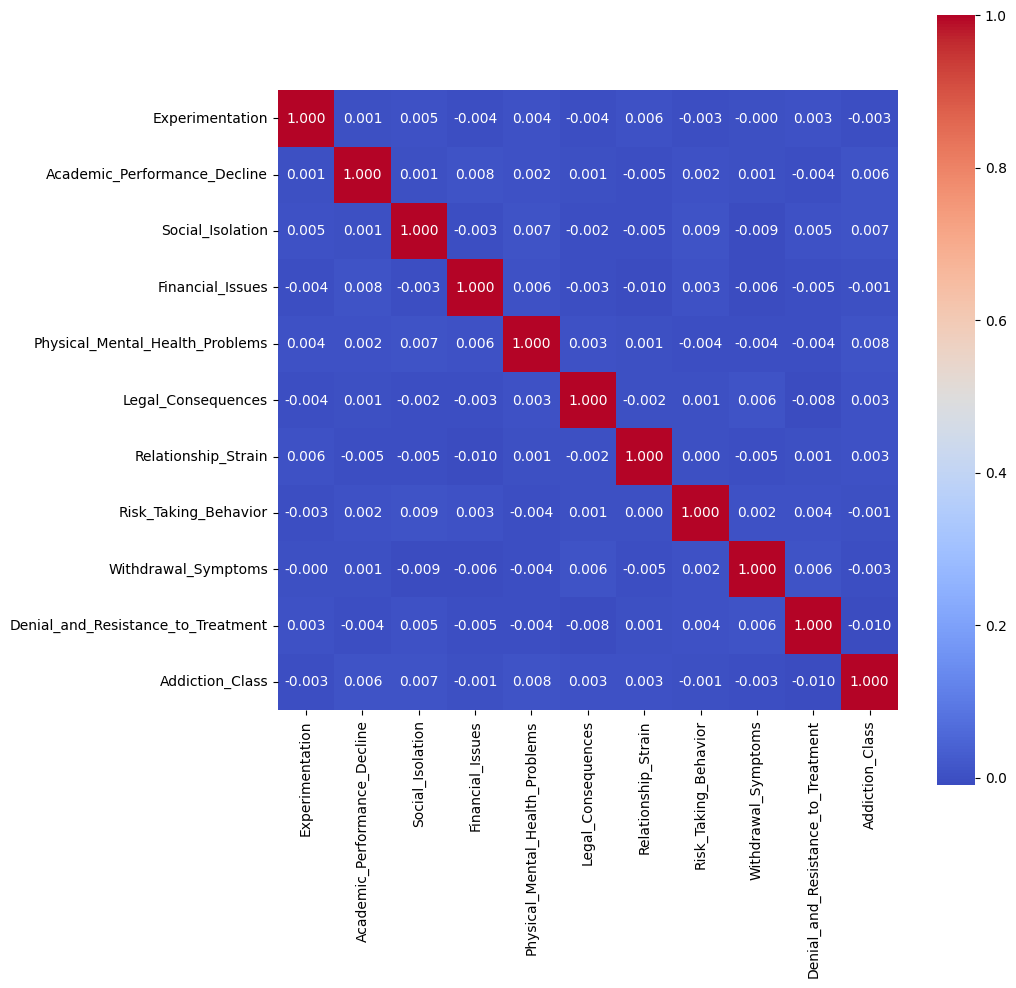

In [48]:
corr = train_df_filtrado.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".3f", cmap='coolwarm', cbar=True, square=True)
plt.show()


# Division de dataset

In [49]:
X_train, y_train = train_df_filtrado.drop(columns=['Addiction_Class']), train_df_filtrado['Addiction_Class']
X_test, y_test = test_df_filtrado.drop(columns=['Addiction_Class']), test_df_filtrado['Addiction_Class']

# Redes Bayesianas

In [50]:
hc = HillClimbSearch(data=train_df_filtrado)
best_model_1 = hc.estimate(scoring_method=BicScore(train_df_filtrado))
print(best_model_1.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[]


In [51]:
est = MmhcEstimator(train_df_filtrado)
best_model_2 = est.estimate(scoring_method=BicScore(train_df_filtrado))
print(best_model_2.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[]


In [52]:
pc = PC(data=train_df_filtrado)
best_model_3 = pc.estimate(scoring_method=BicScore(train_df_filtrado))
print(best_model_3.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

[]


In [53]:
hc = HillClimbSearch(data=train_df_filtrado)
best_model_4 = hc.estimate(scoring_method=BDeuScore(train_df_filtrado))
print(best_model_4.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[]


In [54]:
est = MmhcEstimator(train_df_filtrado)
best_model_5 = est.estimate(scoring_method=BDeuScore(train_df_filtrado))
print(best_model_5.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[]


In [55]:
pc = PC(data=train_df_filtrado)
best_model_6 = pc.estimate(scoring_method=BDeuScore(train_df_filtrado))
print(best_model_6.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

[]


In [56]:
model = BayesianNetwork(best_model_3.edges())
model.fit(train_df_filtrado, estimator=BayesianEstimator, prior_type="BDeu")
for cpd in model.get_cpds():
    print(cpd)